In [1]:
import pandas as pd
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

import timeit

import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup

from collections import Counter

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn as sk
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize


import random

<ipython-input-1-16e06a2cbd53>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook
C:\Users\Ирик\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
feat_cols = ['freq', 'query_results_count_num', 'len_mt', 'len_md', 'len_kw', 'len_w_mt', 'len_w_md', 'len_w_kw', 'words_count', 'words_count_sw', 'spamity', 'max_spam', 'water_content', 'tf_idf', 'density']
target_cols = ['pos', 'real_pos', 'page', 'is_first_page']
df = pd.read_csv('df_to_model_source.csv', sep=';') # df_to_model_source df_to_model
df.head()

,domain,url,freq,query_results_count_num,pos,real_pos,is_first_page,page,search_query_n,len_mt,...,len_w_mt,len_w_md,len_w_kw,words_count,words_count_sw,spamity,max_spam,water_content,tf_idf,density
0,novosibirsk.berfi.ru,http://novosibirsk.berfi.ru/kirpich-bloki/stro...,98,5000000,0.0,0.0,1,0,керамзитобетонный блок в название_город,88,...,12,24,0,1492,1136,0.061837,70,0.241287,0.071440,0.058304
1,www.kora-trading.ru,http://www.kora-trading.ru/novosibirsk/keramzi...,98,5000000,1.0,1.0,1,0,керамзитобетонный блок в название_город,84,...,12,25,10,1233,1010,0.018812,19,0.180860,0.020017,0.016337
2,nsk.pulscen.ru,https://nsk.pulscen.ru/price/100303-bloki-stro...,98,5000000,2.0,2.0,1,0,керамзитобетонный блок в название_город,72,...,10,27,2,1517,1340,0.030597,41,0.116678,0.019660,0.016045
3,penoblok-gazobeton.ru,http://penoblok-gazobeton.ru/novosibirsk/keram...,98,5000000,3.0,3.0,1,0,керамзитобетонный блок в название_город,73,...,8,15,5,1040,984,0.052846,52,0.053846,0.056658,0.046240
4,www.avito.ru,https://www.avito.ru/novosibirsk?q=%D0%BA%D0%B...,98,5000000,4.0,4.0,1,0,керамзитобетонный блок в название_город,112,...,18,59,0,1655,1484,0.038540,57,0.106344,0.024854,0.020284


In [3]:
df.sort_values(by='page')

,domain,url,freq,query_results_count_num,pos,real_pos,is_first_page,page,search_query_n,len_mt,...,len_w_mt,len_w_md,len_w_kw,words_count,words_count_sw,spamity,max_spam,water_content,tf_idf,density
0,novosibirsk.berfi.ru,http://novosibirsk.berfi.ru/kirpich-bloki/stro...,98,5000000,0.0,0.0,1,0,керамзитобетонный блок в название_город,88,...,12,24,0,1492,1136,0.061837,70,0.241287,0.071440,0.058304
17843,beton-stavropol.ru,https://beton-stavropol.ru/,217,9000000,3.0,3.0,1,0,купить бетон название_город,110,...,19,23,0,1970,1675,0.040072,67,0.151269,0.017308,0.015251
17844,www.avito.ru,https://www.avito.ru/stavropol?q=%D0%B1%D0%B5%...,217,9000000,4.0,4.0,1,0,купить бетон название_город,95,...,17,59,0,2029,1742,0.031268,54,0.148842,0.018728,0.016503
17845,stavropol.zoon.ru,https://stavropol.zoon.ru/building/type/beton_...,217,9000000,6.0,5.0,1,0,купить бетон название_город,73,...,14,49,3,1079,900,0.057778,52,0.165894,0.034046,0.030000
17846,stavropol.flagma.ru,https://stavropol.flagma.ru/beton-so218455-1.html,217,9000000,7.0,6.0,1,0,купить бетон название_город,60,...,10,49,0,2352,2086,0.058034,121,0.113520,0.041367,0.036451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6469,legengrad.ru,https://legengrad.ru/doma/premium-doma/komplek...,330,7000000,49.0,87.0,0,4,бетон с доставка название_город,75,...,9,16,0,2349,1761,0.033561,59,0.251596,0.163218,0.152446
6470,tyumen-beton.ru,https://tyumen-beton.ru/keramzitobeton/,330,7000000,51.0,89.0,0,4,бетон с доставка название_город,114,...,20,26,0,1901,1594,0.038969,62,0.163072,0.144235,0.134716
17931,stavropol.zacenoy.ru,https://stavropol.zacenoy.ru/product/keramzito...,9,12000000,54.0,93.0,0,4,купить керамзитобетонный блок в название_город,46,...,5,11,3,543,438,0.054422,24,0.187845,0.022033,0.016629
17964,stavropol.40nog.ru,https://stavropol.40nog.ru/keramzitobetonnye-b...,74,13000000,42.0,81.0,0,4,купить керамзитоблок название_город,93,...,13,33,5,3822,3238,0.058624,190,0.152015,0.001392,0.000926


Wall time: 22.3 s


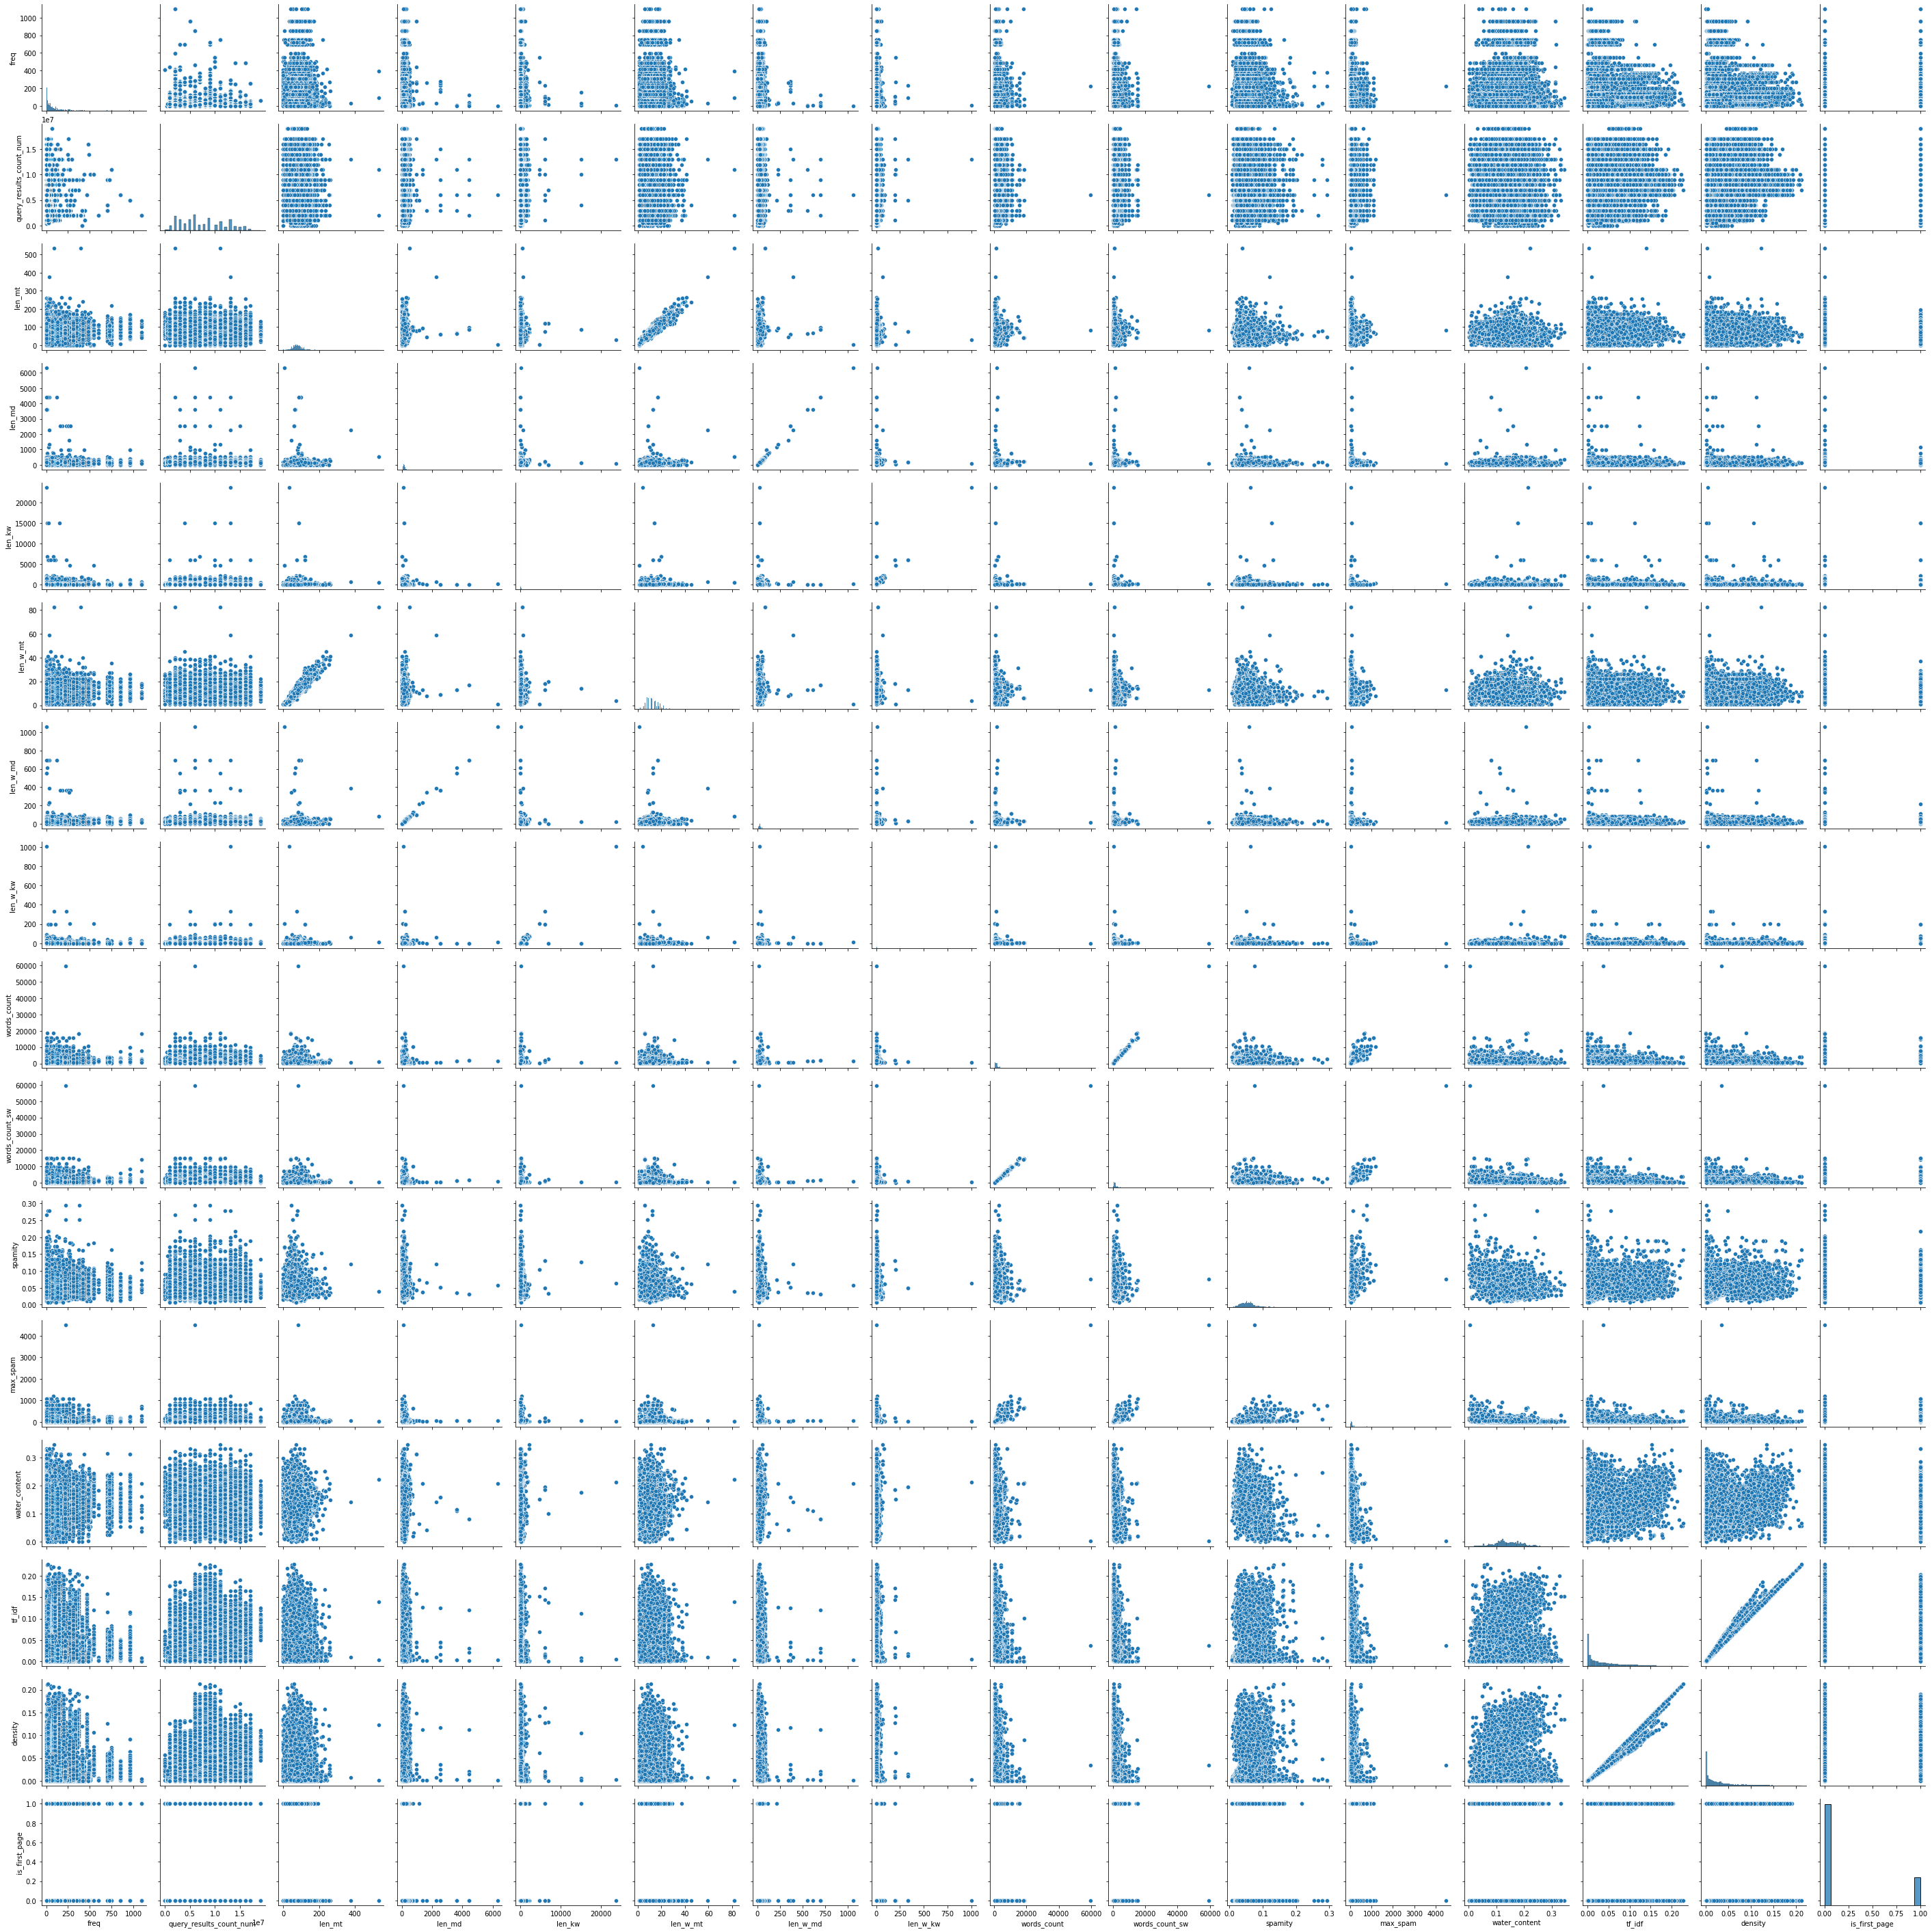

In [4]:
%%time
sns.pairplot(df[feat_cols + ['is_first_page']]) # target_cols = ['pos', 'real_pos', 'page', 'is_first_page']

<AxesSubplot:>

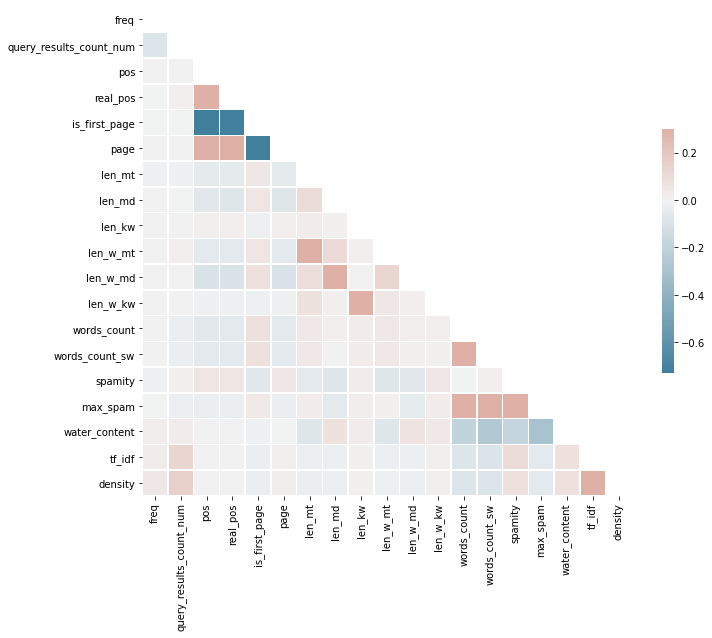

In [5]:
#method{‘pearson’, ‘kendall’, ‘spearman’} 
df_corr = df.corr(method='pearson')
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Распределение значений 
- гистограммы
- ящики с усами

In [6]:
df.describe()

,freq,query_results_count_num,pos,real_pos,is_first_page,page,len_mt,len_md,len_kw,len_w_mt,len_w_md,len_w_kw,words_count,words_count_sw,spamity,max_spam,water_content,tf_idf,density
count,24057.000000,2.405700e+04,24057.000000,24057.000000,24057.000000,24057.000000,24057.000000,24057.000000,24057.000000,24057.00000,24057.000000,24057.000000,24057.000000,24057.000000,24057.000000,24057.000000,24057.000000,24057.000000,24057.000000
mean,97.006443,7.505718e+06,26.230744,43.863823,0.214324,1.943634,78.768051,152.167976,79.817267,11.88652,24.552937,3.772582,1633.431517,1420.032257,0.055723,79.423453,0.140365,0.037129,0.031098
std,139.804206,4.359214e+06,15.231560,28.753660,0.410361,1.418990,29.549972,121.689673,298.073797,4.87118,19.602150,9.844680,1347.178544,1231.020491,0.022620,91.027509,0.049450,0.041920,0.037848
min,0.000000,9.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,1.000000,0.000000,300.000000,215.000000,0.007262,5.000000,0.001049,0.000046,0.000033
25%,13.000000,4.000000e+06,14.000000,21.000000,0.000000,1.000000,61.000000,105.000000,0.000000,9.00000,16.000000,0.000000,810.000000,685.000000,0.040044,34.000000,0.109320,0.003713,0.002630
50%,47.000000,7.000000e+06,26.000000,44.000000,0.000000,2.000000,76.000000,144.000000,30.000000,11.00000,23.000000,1.000000,1340.000000,1171.000000,0.053640,58.000000,0.136119,0.020623,0.015786
75%,120.000000,1.100000e+07,39.000000,67.000000,0.000000,3.000000,96.000000,188.000000,109.000000,15.00000,31.000000,5.000000,1890.000000,1626.000000,0.066421,95.000000,0.176030,0.056658,0.045035
max,1096.000000,1.900000e+07,55.000000,93.000000,1.000000,4.000000,534.000000,6313.000000,23644.000000,82.00000,1057.000000,1002.000000,59558.000000,59310.000000,0.293781,4483.000000,0.345811,0.227110,0.212121


Рассмотрим spamity, water_content, tf_idf, density

In [7]:
cols_to_analyze = ['spamity', 'water_content', 'tf_idf', 'density']

Посмотрим графики для данных на первой странице

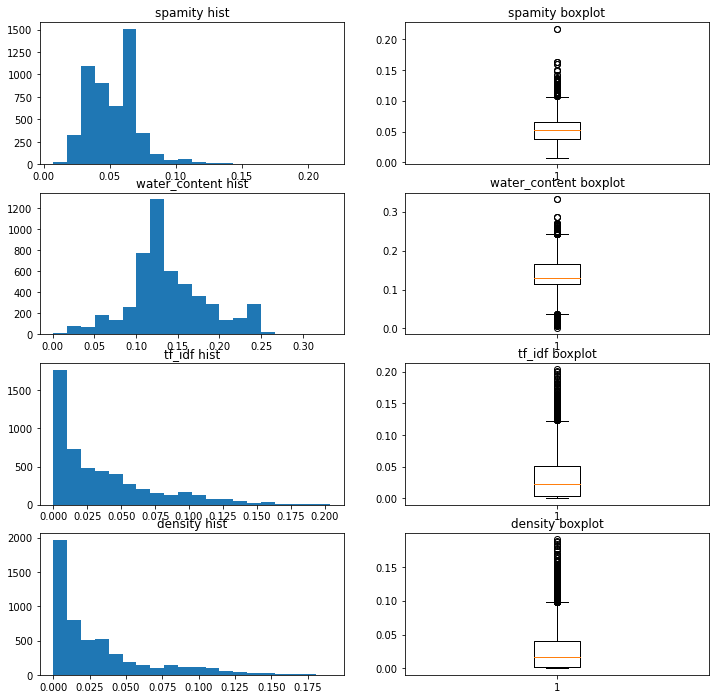

In [8]:
fig, axs = plt.subplots(4, 2, figsize=(12, 12))
n_bins = 20

for i in range(len(cols_to_analyze)):
    col = cols_to_analyze[i]
    axs[i, 0].hist(df[df['page'] == 0][col], bins=n_bins)
    axs[i, 0].set_title(col + ' hist')
    
    axs[i, 1].boxplot(df[df['page'] == 0][col])
    axs[i, 1].set_title(col + ' boxplot')


Есть выбросы в спамности и водности ----------------     попробовать удалить

In [9]:
df.columns

Index(['domain', 'url', 'freq', 'query_results_count_num', 'pos', 'real_pos',
       'is_first_page', 'page', 'search_query_n', 'len_mt', 'len_md', 'len_kw',
       'len_w_mt', 'len_w_md', 'len_w_kw', 'words_count', 'words_count_sw',
       'spamity', 'max_spam', 'water_content', 'tf_idf', 'density'],
      dtype='object')

Запишем границы рекомендуемых значений

In [10]:
borders = {}
borders = {col:[df[col].describe()['25%'], df[col].describe()['75%']] for col in cols_to_analyze}
borders

{'spamity': [0.040043684018929736, 0.06642066420664207],
 'water_content': [0.1093200468933177, 0.1760299625468165],
 'tf_idf': [0.003712642158159217, 0.05665760749627041],
 'density': [0.0026298487836949377, 0.04503464203233257]}

## Нормализация данных

In [11]:
scaler = StandardScaler()
scaler.fit(df[feat_cols])
df[feat_cols] = scaler.transform(df[feat_cols])

# Сэмплирование попробовать

# Для всех запросов

In [12]:
label_gain = df['page'].value_counts().sort_index().index.to_numpy()
#label_gain = np.append(label_gain, 5)
X_train, X_test, y_train, y_test = train_test_split(df[feat_cols], df['page'], test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=42)
query_train = [X_train.shape[0]]
query_val = [X_val.shape[0]]
query_test = [X_test.shape[0]]
groups = y_train.value_counts().sort_index().to_list()
print(groups)
print(query_train)
print(query_val)
print(query_test)

[2437, 2336, 2356, 2207, 2211]
[11547]
[7698]
[4812]


## ранжирование

In [13]:
gbm = lgb.LGBMRanker(
    label_gain=label_gain, 
    max_depth=115, 
    learning_rate=0.1, 
    n_estimators=200, 
    reg_lambda=0.2, 
    reg_alpha=0.1, 
    min_child_samples=251
) 
gbm.fit(X_train, y_train, group=query_train,
        eval_set=[(X_val, y_val)], eval_group=[query_val],
        eval_at=[5, 10, 20], early_stopping_rounds=25)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[1]	valid_0's ndcg@5: 0.408479	valid_0's ndcg@10: 0.457497	valid_0's ndcg@20: 0.489288
Training until validation scores don't improve for 25 rounds
[2]	valid_0's ndcg@5: 0.408479	valid_0's ndcg@10: 0.457497	valid_0's ndcg@20: 0.489288
[3]	valid_0's ndcg@5: 0.408479	valid_0's ndcg@10: 0.457497	valid_0's ndcg@20: 0.489288
[4]	valid_0's ndcg@5: 0.408479	valid_0's ndcg@10: 0.457497	valid_0's ndcg@20: 0.489288
[5]	valid_0's ndcg@5: 0.408479	valid_0's ndcg@10: 0.457497	valid_0's ndcg@20: 0.489288
[6]	valid_0's ndcg@5: 0.408479	valid_0's ndcg@10: 0.457497	valid_0's ndcg@20: 0.489288
[7]	valid_0's ndcg@5: 0.408479	valid_0's ndcg@10: 0.457497	valid_0's ndcg@20: 0.489288
[8]	valid_0's ndcg@5: 0.408479	valid_0's ndcg@10: 0.457497	valid_0's ndcg@20: 0.489288
[9]	valid_0's ndcg@5: 0.408479	valid_0's ndcg@10: 0.457497	valid_0's ndcg@20: 0.489288
[10]	valid_0's ndcg@5: 0.4

LGBMRanker(label_gain=array([0, 1, 2, 3, 4], dtype=int64), max_depth=115,
           min_child_samples=251, n_estimators=200, reg_alpha=0.1,
           reg_lambda=0.2)

In [14]:
#x1 = X_test[0:1].reset_index(drop=True)
test_pred = gbm.predict(X_test)
#X_test["predicted_ranking"] = test_pred
#X_test.sort_values("predicted_ranking", ascending=False)

In [15]:
#X_test["predicted_ranking"].hist()

## Классификация бинарная

<AxesSubplot:>

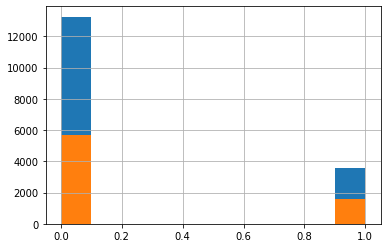

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df[feat_cols], df['is_first_page'], test_size=0.3, random_state=42)
y_train.hist()
y_test.hist()

In [17]:
%%time
"""

parametrs = { 
    'n_estimators': range (75, 151, 25),
    'max_depth': range (5,16, 5),
    'learning_rate': [0.1, 0.5, 0.7],
    'random_state': [42]
}

GBC = GradientBoostingClassifier()
grid = GridSearchCV(GBC, parametrs, cv=5)
grid.fit(X_train, y_train)

#GBC.fit(X_train, y_train)
#pred_GBC = GBC.predict(X_test)
#roc_auc_score(y_test, pred_GBC)
grid.best_params_
"""

Wall time: 0 ns


"\n\nparametrs = { \n    'n_estimators': range (75, 151, 25),\n    'max_depth': range (5,16, 5),\n    'learning_rate': [0.1, 0.5, 0.7],\n    'random_state': [42]\n}\n\nGBC = GradientBoostingClassifier()\ngrid = GridSearchCV(GBC, parametrs, cv=5)\ngrid.fit(X_train, y_train)\n\n#GBC.fit(X_train, y_train)\n#pred_GBC = GBC.predict(X_test)\n#roc_auc_score(y_test, pred_GBC)\ngrid.best_params_\n"

In [18]:
#grid.best_params_

In [19]:
GBC = GradientBoostingClassifier(learning_rate=0.5,
 max_depth=15,
 n_estimators= 150,
 random_state = 42
)
GBC.fit(X_train, y_train)
pred_GBC = GBC.predict(X_test)
roc_auc_score(y_test, pred_GBC)

0.8439649639863595

In [20]:
%%time
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               #'class_weight': ['balanced'],
             }
rfc = RandomForestClassifier()
rs = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Wall time: 2min 42s


{'n_estimators': 600,
 'min_samples_split': 23,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 15,
 'bootstrap': False}

In [21]:
RF = RandomForestClassifier(
    n_estimators=600, 
    max_depth=15, 
    random_state=42, 
    min_samples_split=23,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=False
)
RF.fit(X_train, y_train)
pred_rf = RF.predict(X_test)
#round(RF.score(X_test,y_test), 4)
roc_auc_score(y_test, pred_rf)

0.7918579731922233

In [22]:
%%time
NN = MLPClassifier(
    solver='lbfgs', 
    alpha=1e-5, 
    hidden_layer_sizes=(8, 3), 
    random_state=42, 
    activation='tanh',
    learning_rate='adaptive',
    max_iter=5000
) #relu
NN.fit(X_train, y_train)
pred_nn = NN.predict(X_test)
#round(NN.score(X_test,y_test), 4)
roc_auc_score(y_test, pred_nn)

Wall time: 7.18 s


0.7367194583651464

In [23]:
pred_random = [random.randint(0, 1) for i in range(len(y_test))]
roc_auc_score(y_test, pred_random)

0.4995899545991318

## мультикласс

<AxesSubplot:>

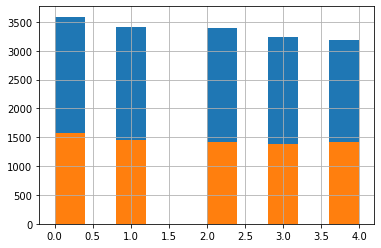

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df[feat_cols], df['page'], test_size=0.3, random_state=42)
y_train.hist()
y_test.hist()

In [25]:
labels = [0, 1, 2, 3, 4]
y_test = label_binarize(y_test, classes=labels)

In [26]:
%%time
GBC = GradientBoostingClassifier(
    n_estimators=150, 
    learning_rate=0.5, 
    max_depth=20, 
    random_state=42
)
GBC.fit(X_train, y_train)
pred_GBC = GBC.predict(X_test)
pred_GBC = label_binarize(pred_GBC, classes=labels)
roc_auc_score(y_test, pred_GBC, average='macro', multi_class='ovo')

Wall time: 3min 18s


0.7306171275498066

In [27]:
RF = RandomForestClassifier(n_estimators=600, max_depth=15, random_state=42)
RF.fit(X_train, y_train)
pred_rf = RF.predict(X_test)
pred_rf = label_binarize(pred_rf, classes=labels)
roc_auc_score(y_test, pred_rf,average='macro', multi_class='ovo')

0.7395101696142243

In [28]:
pred_random = [random.randint(0, 5) for i in range(len(y_test))]
pred_random = label_binarize(pred_random, classes=labels)
roc_auc_score(y_test, pred_random)

0.5044762008579345

## Регрессия

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df[feat_cols], df['page'], test_size=0.3, random_state=42)

In [30]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

C:\Users\Ирик\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.2745912995289554

# Для одного запроса

In [31]:
queries = df['search_query_n'].unique()
queries

array(['керамзитобетонный блок в название_город',
       'керамзитоблок название_город', 'фбс название_город',
       'бетон с доставка название_город',
       'керамзитобетонный блок название_город',
       'керамзитный блок название_город',
       'плита перекрытие название_город', 'купить бетон название_город',
       'купить керамзитобетонный блок в название_город',
       'купить керамзитоблок название_город', 'купить фбс название_город',
       'купить бетон с доставка название_город',
       'купить плита перекрытие название_город'], dtype=object)

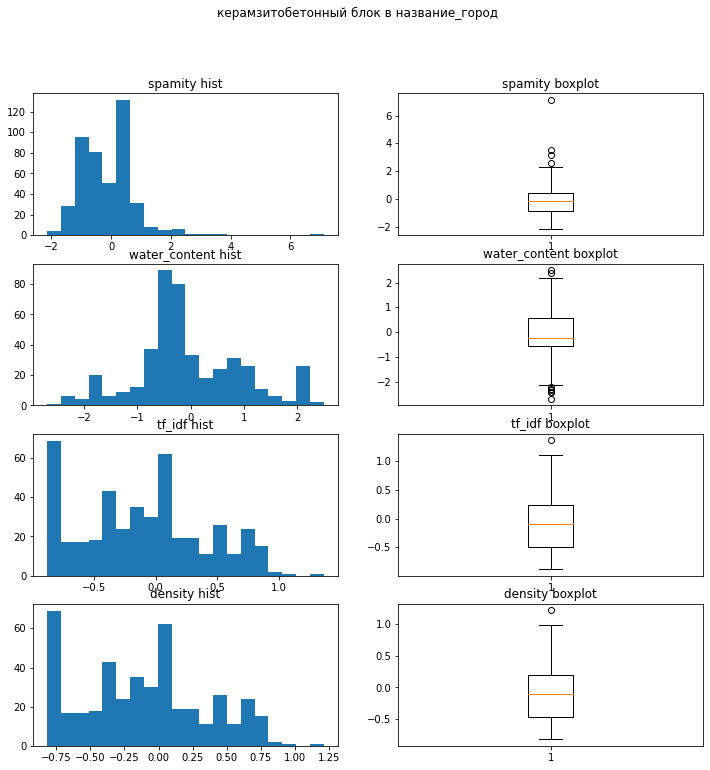

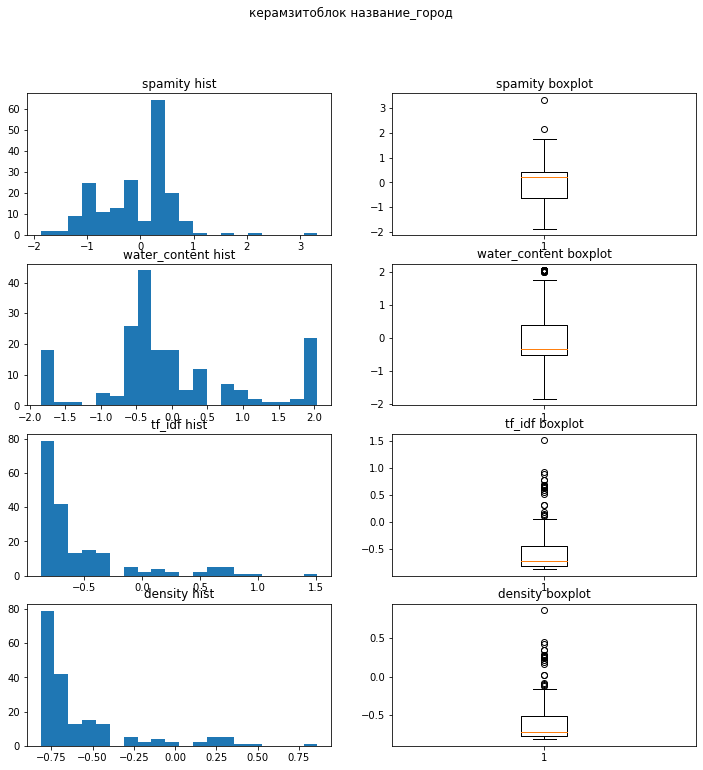

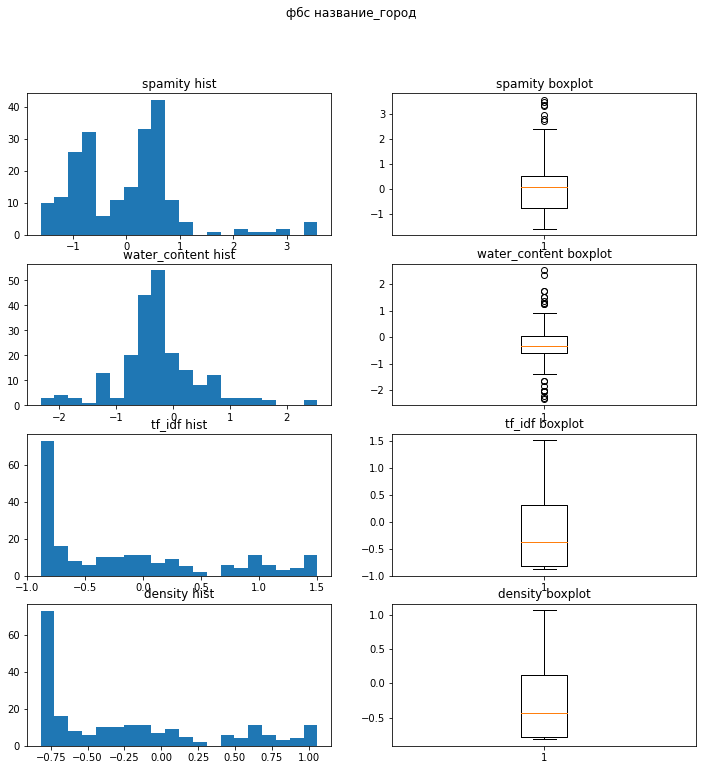

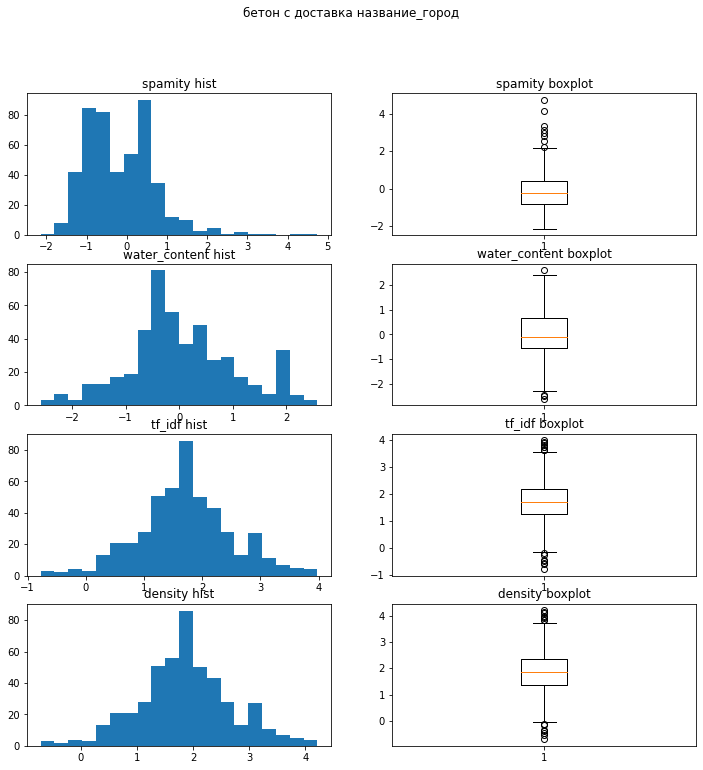

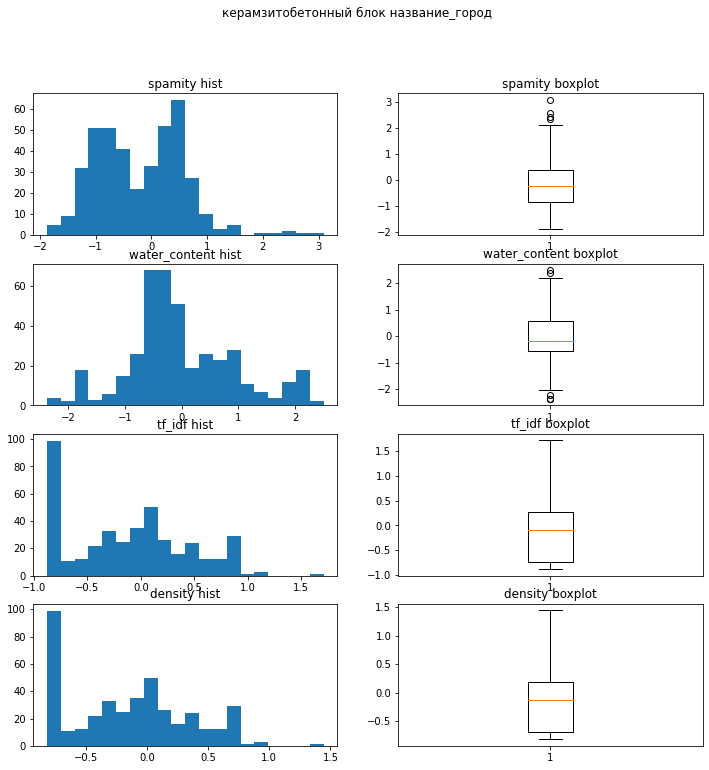

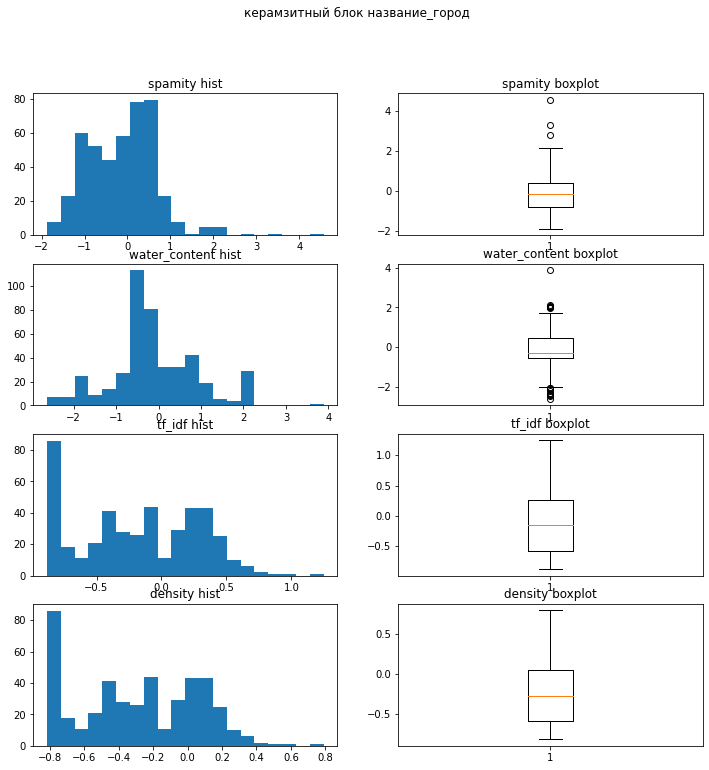

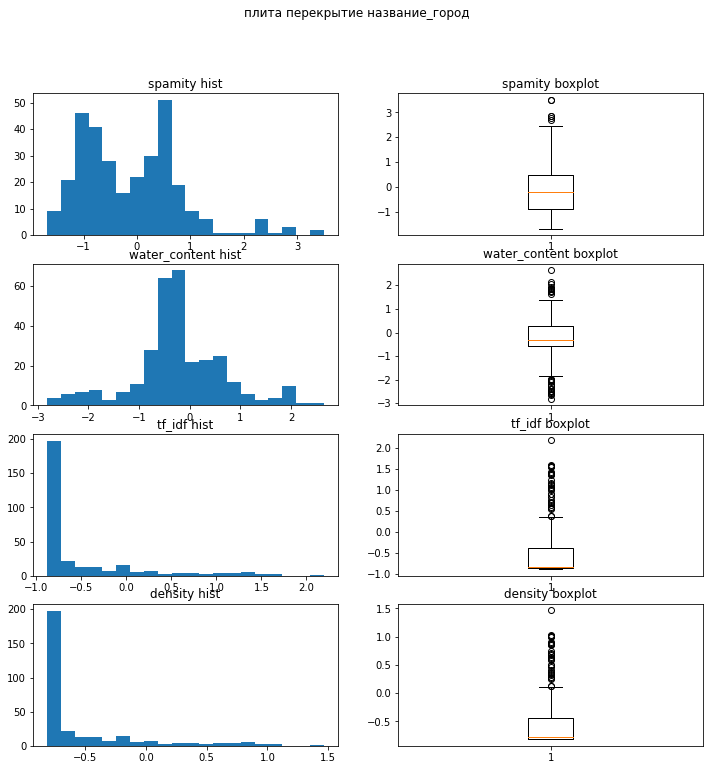

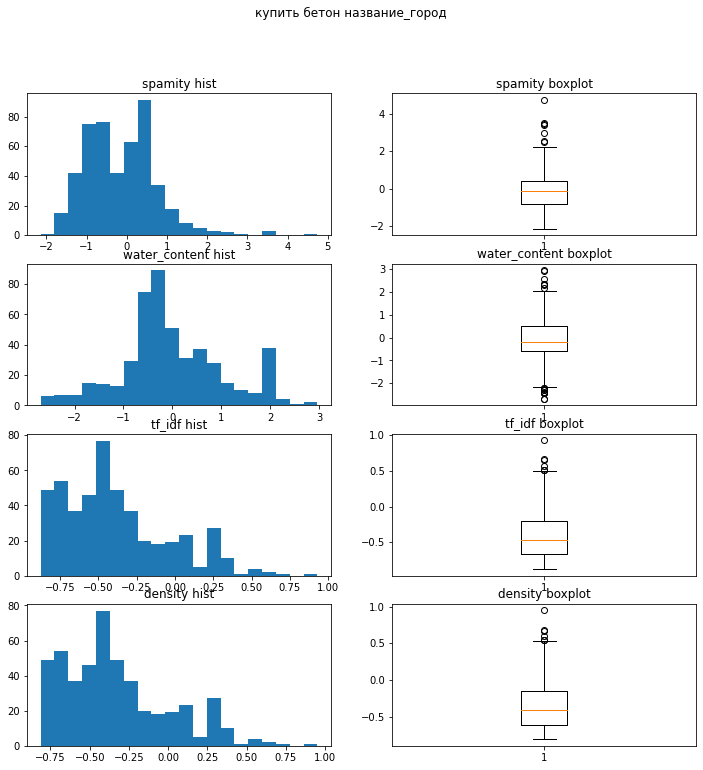

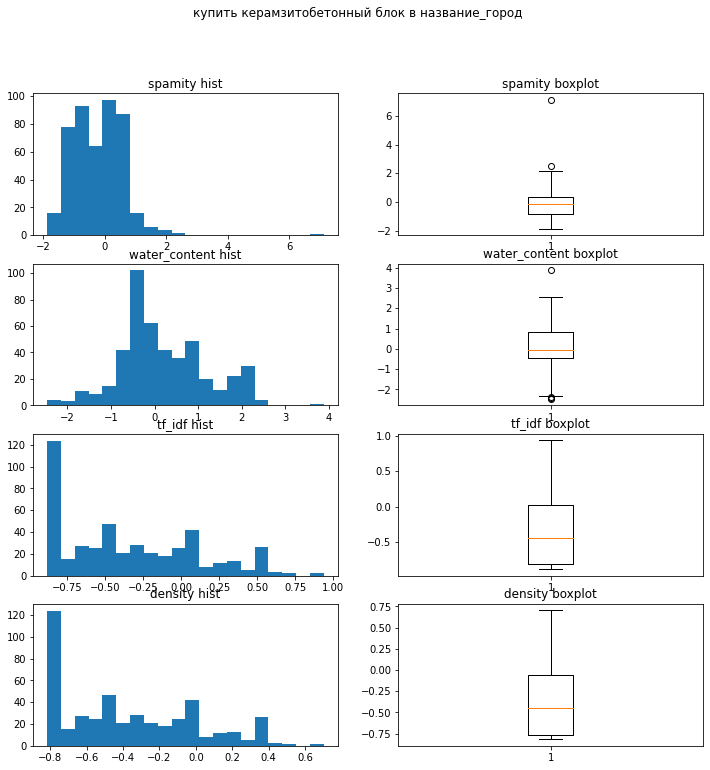

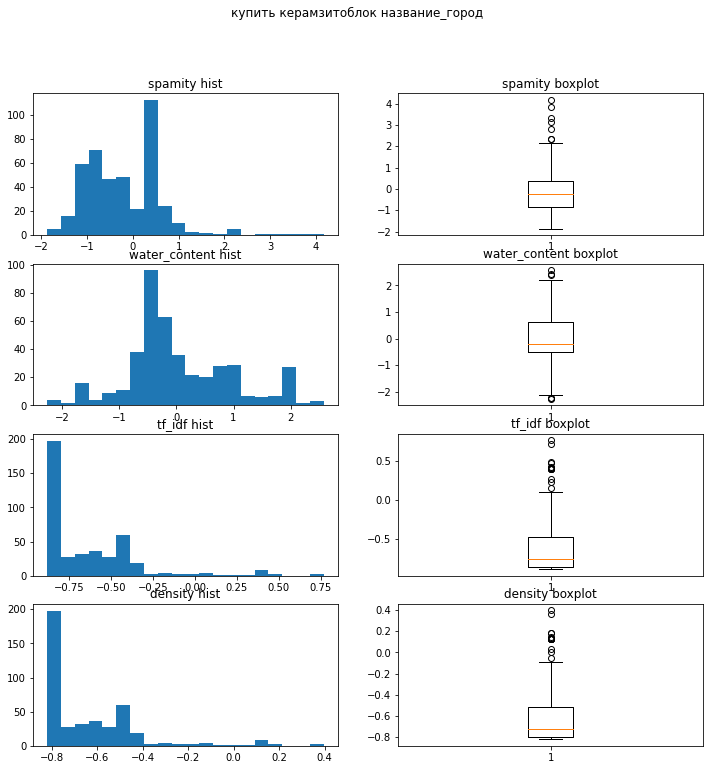

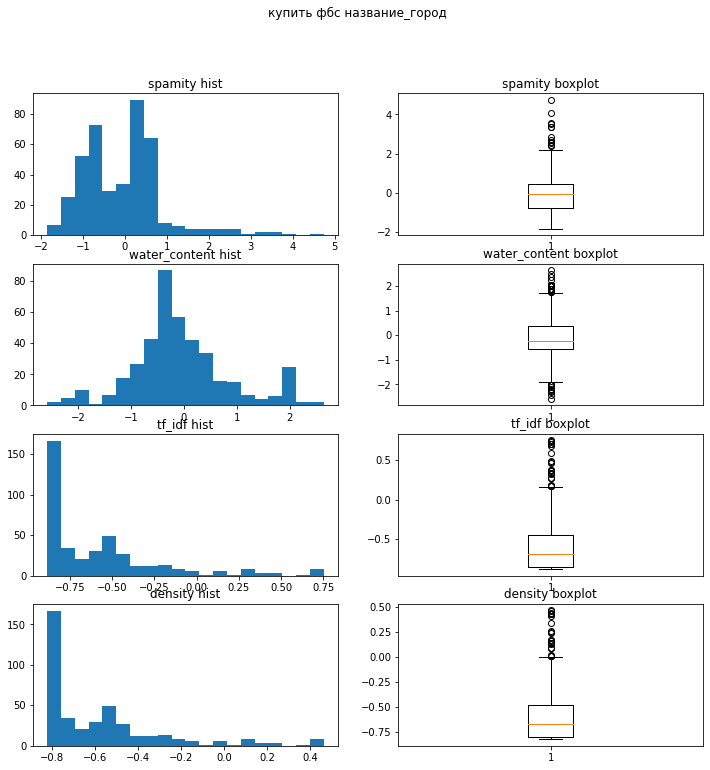

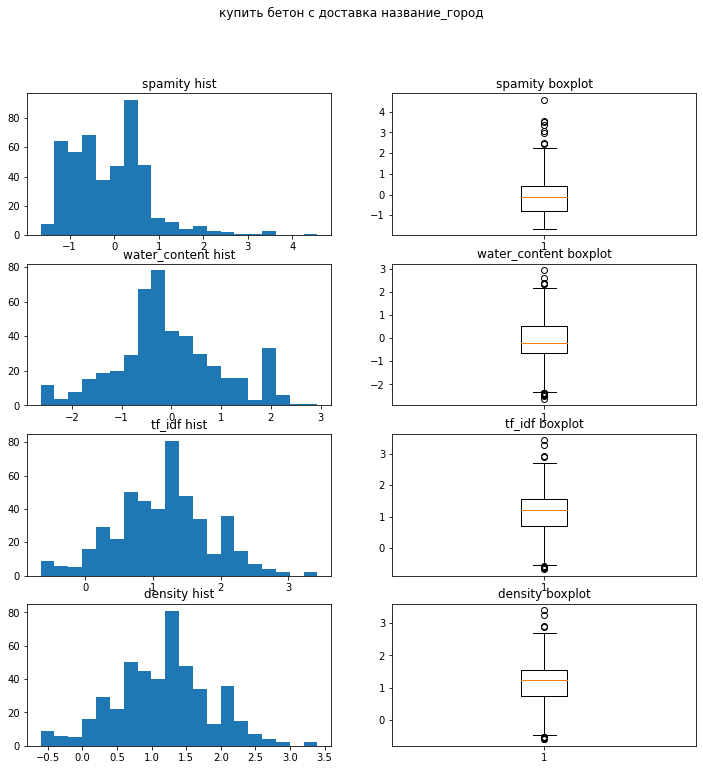

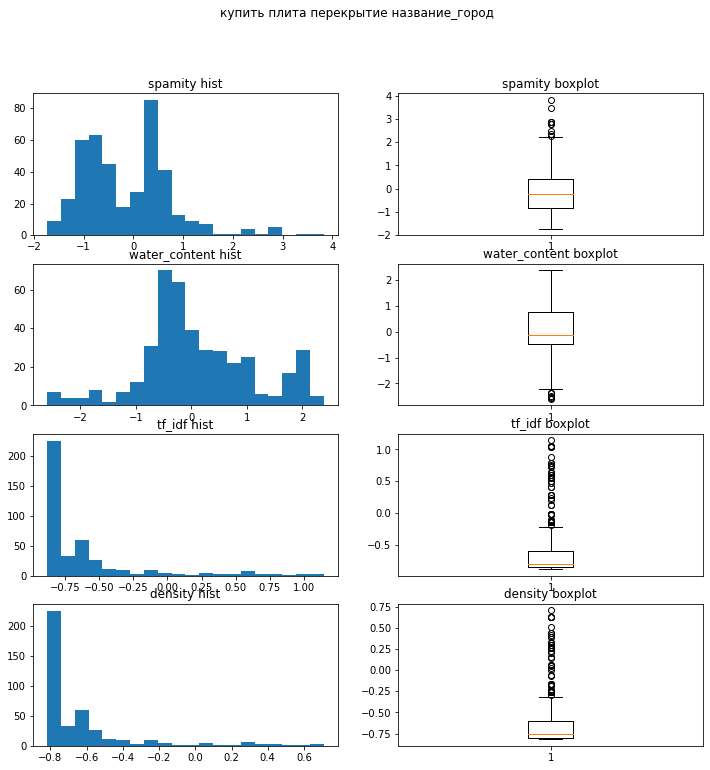

In [32]:
for query in queries:
    fig, axs = plt.subplots(4, 2, figsize=(12, 12))
    n_bins = 20
    plt.suptitle(query)
    for i in range(len(cols_to_analyze)):
        col = cols_to_analyze[i]
        axs[i, 0].hist(df[(df['page'] == 0) & (df['search_query_n'] == query)][col], bins=n_bins)
        axs[i, 0].set_title(col + ' hist')

        axs[i, 1].boxplot(df[(df['page'] == 0) & (df['search_query_n'] == query)][col])
        axs[i, 1].set_title(col + ' boxplot')


## Классификация бинарная

<AxesSubplot:>

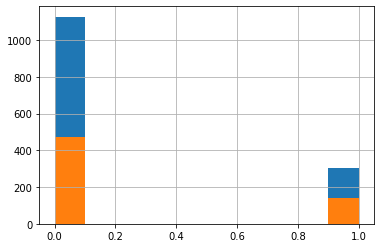

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    df[df['search_query_n']==queries[0]][feat_cols], 
    df[df['search_query_n']==queries[0]]['is_first_page'], 
    test_size=0.3, 
    random_state=42
)
y_train.hist()
y_test.hist()

In [34]:
LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr').fit(X_train, y_train)
pred_lr = LR.predict(X_test)
#LR.predict(X_train)
#round(LR.score(X_test,y_test), 4)
roc_auc_score(y_test, pred_lr)

0.5050331525015069

In [35]:
SVM = svm.LinearSVC(random_state=42)
SVM.fit(X_train, y_train)
#round(SVM.score(X_test,y_test), 4)
pred_svm = SVM.predict(X_test)
roc_auc_score(y_test, pred_svm)

C:\Users\Ирик\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.5050331525015069

In [36]:
RF = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)
RF.fit(X_train, y_train)
pred_rf = RF.predict(X_test)
#round(RF.score(X_test,y_test), 4)
roc_auc_score(y_test, pred_rf)

0.7324743821579264

## Обучим модели для каждого запроса

In [37]:
import joblib, pickle

In [38]:
def transliterate(name):
   """
   Автор: LarsKort
   Дата: 16/07/2011; 1:05 GMT-4;
   Не претендую на "хорошесть" словарика. В моем случае и такой пойдет,
   вы всегда сможете добавить свои символы и даже слова. Только
   это нужно делать в обоих списках, иначе будет ошибка.
   """
   # Слоаврь с заменами
   slovar = {'а':'a','б':'b','в':'v','г':'g','д':'d','е':'e','ё':'yo',
      'ж':'zh','з':'z','и':'i','й':'i','к':'k','л':'l','м':'m','н':'n',
      'о':'o','п':'p','р':'r','с':'s','т':'t','у':'u','ф':'f','х':'h',
      'ц':'c','ч':'ch','ш':'sh','щ':'sch','ъ':'','ы':'y','ь':'','э':'e',
      'ю':'u','я':'ya', 'А':'A','Б':'B','В':'V','Г':'G','Д':'D','Е':'E','Ё':'YO',
      'Ж':'ZH','З':'Z','И':'I','Й':'I','К':'K','Л':'L','М':'M','Н':'N',
      'О':'O','П':'P','Р':'R','С':'S','Т':'T','У':'U','Ф':'F','Х':'H',
      'Ц':'C','Ч':'CH','Ш':'SH','Щ':'SCH','Ъ':'','Ы':'y','Ь':'','Э':'E',
      'Ю':'U','Я':'YA',',':'','?':'',' ':'_','~':'','!':'','@':'','#':'',
      '$':'','%':'','^':'','&':'','*':'','(':'',')':'','-':'','=':'','+':'',
      ':':'',';':'','<':'','>':'','\'':'','"':'','\\':'','/':'','№':'',
      '[':'',']':'','{':'','}':'','ґ':'','ї':'', 'є':'','Ґ':'g','Ї':'i',
      'Є':'e', '—':''}
        
   # Циклически заменяем все буквы в строке
   for key in slovar:
      name = name.replace(key, slovar[key])
   return name
transliterate('Я вас категорически приветствую!')

'YA_vas_kategoricheski_privetstvuu'

In [39]:
feat_cols

['freq',
 'query_results_count_num',
 'len_mt',
 'len_md',
 'len_kw',
 'len_w_mt',
 'len_w_md',
 'len_w_kw',
 'words_count',
 'words_count_sw',
 'spamity',
 'max_spam',
 'water_content',
 'tf_idf',
 'density']

In [40]:
#scaler = StandardScaler()
#scaler.fit(df_query[feat_cols])
#scaler.transform(df_query[feat_cols])

NameError: name 'df_query' is not defined

In [41]:
predicts_score = list()

In [62]:
models_per_q = dict()
for query in queries:
    df_query = df[df['search_query_n'] == query]
    X_train, X_test, y_train, y_test = train_test_split(
        df_query[feat_cols], 
        #scaler.transform(df_query[feat_cols]),
        df_query['is_first_page'], # is_first_page, page
        test_size=0.3, 
        random_state=42
    )
    
    #labels = [0, 1, 2, 3, 4]
    #y_test = label_binarize(y_test, classes=labels)
    
    RF = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42) # binary
    #RF = RandomForestClassifier(n_estimators=350, max_depth=15, random_state=42) # pages
    RF.fit(X_train, y_train)
    pred_rf = RF.predict(X_test)
    #pred_rf = label_binarize(pred_rf, classes=labels)
    #print(roc_auc_score(y_test, pred_rf,average='macro', multi_class='ovo'))     # pages
    print(roc_auc_score(y_test, pred_rf)) # binary
    """
    
    GBC = GradientBoostingClassifier(
        learning_rate=0.1,
         max_depth=30,
         n_estimators= 200,
         loss='exponential',
         random_state = 42
    )
    GBC.fit(X_train, y_train)
    pred_GBC = GBC.predict(X_test)
    print(roc_auc_score(y_test, pred_GBC))
    """

    
    models_per_q[query] = dict()
    print(query)
    filename = transliterate(query)+'.sav'
    models_per_q[query]['model'] = filename
    joblib.dump(RF, filename)
    #joblib.dump(GBC, filename)
    

    models_per_q[query]['borders'] = {
        col:[df_query[df_query['page'] == 0][col].describe()['25%'], 
             df_query[df_query['page'] == 0][col].describe()['75%']] 
        for col in cols_to_analyze
    }
    print(models_per_q[query])
    print()
a_file = open("query_dict_data.pkl", "wb")
pickle.dump(models_per_q, a_file)
a_file.close()

0.7324743821579264
керамзитобетонный блок в название_город
{'model': 'keramzitobetonnyi_blok_v_nazvanie_gorod.sav', 'borders': {'spamity': [-0.8294693427409161, 0.4199880337156804], 'water_content': [-0.5414763743688098, 0.5735069398787759], 'tf_idf': [-0.4922188407450179, 0.23292517791203904], 'density': [-0.4659406180225539, 0.18953507750594728]}}

0.7739099859353025
керамзитоблок название_город
{'model': 'keramzitoblok_nazvanie_gorod.sav', 'borders': {'spamity': [-0.6292798972319272, 0.4028703242354812], 'water_content': [-0.5055371891699938, 0.3938686154507985], 'tf_idf': [-0.8108158949548966, -0.44981991467834415], 'density': [-0.7690772128078887, -0.515745044012201]}}

0.7123797025371829
фбс название_город
{'model': 'fbs_nazvanie_gorod.sav', 'borders': {'spamity': [-0.7792905343778022, 0.5342682789350697], 'water_content': [-0.5817368281685923, 0.03518352819512313], 'tf_idf': [-0.8291281622779377, 0.30339517800287813], 'density': [-0.7771051689650083, 0.11412013159443496]}}

0.69

In [ ]:
X_train

## мультикласс

In [ ]:
labels = [0, 1, 2, 3, 4]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df[df['search_query_n']==queries[3]][feat_cols], 
    df[df['search_query_n']==queries[3]]['page'], 
    test_size=0.3, 
    random_state=42
)
y_train.hist()
y_test.hist()

In [ ]:
RF = RandomForestClassifier(n_estimators=115, max_depth=15, random_state=42)
RF.fit(X_train, y_train)
pred_rf = RF.predict(X_test)
y_test = label_binarize(y_test, classes=labels)
pred_rf = label_binarize(pred_rf, classes=labels)
roc_auc_score(y_test, pred_rf,average='macro', multi_class='ovo')

In [ ]:
pred_random = [random.randint(0, 5) for i in range(len(y_test))]
pred_random = label_binarize(pred_random, classes=labels)
roc_auc_score(y_test, pred_random)

# Для одного города

# Другое